In [0]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm


Using TensorFlow backend.


This technique is also called transfer learning, we don’t have to do everything on our own, we use the pre-trained model that have been already trained on large datasets and extract the features from these models and use them for our tasks. We are using the Xception model which has been trained on imagenet dataset that had 1000 different classes to classify. We can directly import this model from the keras.applications . Make sure you are connected to the internet as the weights get automatically downloaded. Since the Xception model was originally built for imagenet, we will do little changes for integrating with our model. One thing to notice is that the Xception model takes 299*299*3 image size as input. We will remove the last classification layer and get the 2048 feature vector.



In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import os
os.chdir("/content/drive/My Drive/text-to-image")
os.listdir()

Mounted at /content/drive


['Flickr8k_Dataset',
 'data',
 'Flickr8k_text',
 'birds',
 'logs',
 'results',
 'CUB_200_2011',
 'src-juan',
 'src-paola',
 'src-ely',
 'ToDo.gdoc',
 'embeddings',
 'img']

In [0]:
# Copy files from Google Drive to the VM local filesystem
!cp -r "/content/drive/My Drive/text-to-image/data/processed/normalized_images" ./img

KeyboardInterrupt: ignored

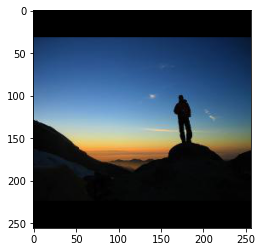

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import rescale
from skimage import img_as_ubyte
IMG_DIR = "./data/processed/normalized_images/"
img = "58368365_03ed3e5bdf_1.jpg"

I = imread(IMG_DIR + img)
plt.imshow(I)

In [0]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        all_images = os.listdir(directory)
        for img in tqdm(all_images):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features
#2048 feature vector

#dataset_images = "./data/processed/normalized_images/"
#features = extract_features(dataset_images)
#dump(features, open("features_256.pickle","wb"))

dataset_images = "./data/processed/normalized_64_complete/"
features = extract_features(dataset_images)
dump(features, open("features_64.pickle","wb"))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Buffered data was truncated after reaching the output size limit.

In [0]:
dataset_images = "./data/processed/normalized_images/"
features = extract_features(dataset_images)
dump(features, open("features_256.pickle","wb"))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


KeyboardInterrupt: ignored

In [0]:
from pickle import dump, load

with open("./embeddings/emb_train.pickle","rb") as f:
  emb_train = load(f)

with open("./embeddings/emb_test.pickle","rb") as f:
  emb_test = load(f)

with open("./embeddings/emb_val.pickle","rb") as f:
  emb_val = load(f)

with open("./embeddings/x_train_name.pickle","rb") as f:
  x_train_name = load(f)

with open("./embeddings/x_test_name.pickle","rb") as f:
  x_test_name = load(f)

with open("./embeddings/x_val_name.pickle","rb") as f:
  x_val_name = load(f)

with open("features_256.pickle","rb") as f:
  features = load(f)

In [0]:
# load sets 
import re
X_test = []
E_test = []
F_test = []

#images = list(x_test_name)
IMG_DIR = "./data/processed/normalized_images/"
for image,emb in zip(x_test_name, emb_test):
    try: 
        new_name = image[:-6] + '_' + image[-1] + '.jpg'
        I = imread(IMG_DIR + new_name)
        X_test.append(I)
        E_test.append(emb)
        F_test.append(features[new_name][0])
    except Exception as error:
        print(error)
        print(image)
        pass
dump(X_test, open("./data/X_test_256.pickle","wb"))

# load sets 
X_train = []
E_train = []
F_train = []
images = list(x_train_name)

for image,emb in zip(x_train_name, emb_train):
    try: 
        new_name = image[:-6] + '_' + image[-1] + '.jpg'
        I = imread(IMG_DIR + new_name)
        X_train.append(I)
        E_train.append(emb)
        F_train.append(features[new_name][0])
    except Exception as error:
        print(error)
        print(image)
        pass

dump(X_train, open("./data/X_train_256.pickle","wb"))


In [0]:
# load sets 
import re
X_test = []
E_test = []
F_test = []

IMG_DIR = "./data/processed/normalized_64_complete/"
with open("features.pickle","rb") as f:
  features = load(f)
  

images = list(x_test_name)

for image,emb in zip(x_test_name, emb_test):
    try: 
        new_name = image[:-6] + '_' + image[-1] + '.jpg'
        I = imread(IMG_DIR + new_name)
        X_test.append(I)
        E_test.append(emb)
        F_test.append(features[new_name][0])
    except Exception as error:
        print(error)
        print(image)
        pass
dump(X_test, open("./data/X_test.pickle","wb"))
dump(E_test, open("./data/E_test.pickle","wb"))
dump(F_test, open("./data/F_test.pickle","wb"))

# load sets 
X_train = []
E_train = []
F_train = []
images = list(x_train_name)

for image,emb in zip(x_train_name, emb_train):
    try: 
        new_name = image[:-6] + '_' + image[-1] + '.jpg'
        I = imread(IMG_DIR + new_name)
        X_train.append(I)
        E_train.append(emb)
        F_train.append(features[new_name][0])
    except Exception as error:
        print(error)
        print(image)
        pass

dump(X_train, open("./data/X_train.pickle","wb"))
dump(E_train, open("./data/E_train.pickle","wb"))
dump(F_train, open("./data/F_train.pickle","wb"))